In [103]:
from language_analysis import load_latest_interaction, load_all_interactions
import math
import torch
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from egg.core.language_analysis import TopographicSimilarity

In [120]:
interaction_obj = load_latest_interaction(
    logs_root="../logs/interactions/2025-06-16",
    seed_folder="gamesize10_bee_gs_seed42",
    split="validation",
    prefix="interaction_gpu0"
)

../logs/interactions/2025-06-16/gamesize10_bee_gs_seed42/interactions/validation/epoch_39/interaction_gpu0


In [121]:
vocab_size = 8
predicted_directions = interaction_obj.message[:, :8].argmax(dim=-1).tolist()
predicted_distances = interaction_obj.message[:, 8].tolist()

In [122]:
nest_positions = interaction_obj.aux_input['nest_pos']
food_positions = interaction_obj.aux_input['food_pos']

ground_truth_direction_ids = []
ground_truth_distance_values = []

for i in range(len(nest_positions)):
    start_pos = nest_positions[i]
    end_pos = food_positions[i]

    # Calculate the vector (dx, dy)
    dx = end_pos[0] - start_pos[0]
    dy = end_pos[1] - start_pos[1]
    
    # Calculate the straight-line (Euclidean) distance
    distance = torch.hypot(dx, dy).item()
    ground_truth_distance_values.append(distance)
    
    # Calculate the angle in degrees and convert to direction
    angle = math.degrees(math.atan2(dy, dx)) % 360
    direction_vocab = ["N", "NE", "E", "SE", "S", "SW", "W", "NW"]
    direction = int((angle + 22.5) // 45) % vocab_size

    ground_truth_direction_ids.append(direction)

In [123]:
from scipy.stats import spearmanr
from sklearn.metrics import mutual_info_score
mi_score = mutual_info_score(ground_truth_direction_ids, predicted_directions)
print(f"Mutual Information Score: {mi_score:.4f}")
print("(A higher score means the predicted token is a better indicator of the true direction)")

Mutual Information Score: 0.1186
(A higher score means the predicted token is a better indicator of the true direction)


## Does higher distance maps to farther ground truth distance? and does direction token maps to ground truth direction?
Spearsman correlation: A perfect positive monotonic relationship would give ρ = +1. A perfect negative relationship would be ρ = –1.
Pairwise ranking: How often the predicted‐score ordering matches the true‐distance ordering.

In [124]:
rho, p_value = spearmanr(ground_truth_distance_values, predicted_distances)
print(f"Spearman's Rank Correlation (rho): {rho:.4f}")
print(f"P-value: {p_value}")
print("(A rho value close to 1.0 means the agent successfully learned to encode distance)")

Spearman's Rank Correlation (rho): 0.0216
P-value: 0.3345467529247922
(A rho value close to 1.0 means the agent successfully learned to encode distance)


# Human Analysis

In [88]:
logs = load_latest_interaction(
    logs_root="../logs/interactions/2025-06-16",
    seed_folder="gamesize10_human_gs_seed42",
    split="validation",
    prefix="interaction_gpu0"
)

../logs/interactions/2025-06-16/gamesize10_human_gs_seed42/interactions/validation/epoch_40/interaction_gpu0


In [90]:
human_messages = logs.message.argmax(dim=-1)
human_messages= [msg.tolist() for msg in human_messages]
print(f"Messages: {human_messages}")

Messages: [[98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 0], [11, 7, 11, 7, 11, 11, 7, 11, 7, 11, 0], [39, 80, 11, 57, 57, 57, 57, 57, 57, 57, 0], [67, 67, 67, 65, 67, 65, 67, 65, 67, 98, 0], [80, 80, 80, 58, 58, 58, 58, 47, 80, 58, 0], [80, 58, 42, 80, 42, 80, 42, 80, 42, 80, 0], [39, 39, 26, 26, 81, 26, 81, 26, 81, 26, 0], [80, 80, 80, 65, 47, 65, 47, 47, 80, 47, 0], [39, 39, 42, 42, 42, 42, 42, 42, 42, 42, 0], [39, 39, 39, 39, 80, 26, 26, 32, 32, 47, 0], [80, 42, 42, 81, 81, 81, 81, 81, 81, 81, 0], [26, 60, 60, 60, 60, 60, 60, 60, 60, 60, 0], [39, 39, 39, 39, 80, 67, 67, 57, 98, 67, 0], [26, 26, 26, 32, 32, 32, 32, 32, 32, 32, 0], [80, 80, 26, 58, 58, 58, 58, 58, 58, 58, 0], [39, 39, 97, 97, 97, 97, 7, 97, 7, 7, 0], [39, 39, 39, 39, 7, 7, 67, 7, 67, 7, 0], [97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 0], [80, 80, 81, 42, 81, 81, 81, 58, 81, 81, 0], [39, 39, 97, 97, 7, 7, 7, 7, 7, 7, 0], [47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 0], [39, 75, 75, 75, 97, 75, 97, 81, 97, 81, 0], [43, 43, 43, 43,

In [143]:
nest = np.stack(logs.aux_input["nest_pos"])
food = np.stack(logs.aux_input["food_pos"])

In [108]:
delta = food - nest
Euclidean_distance = np.linalg.norm(delta, axis=1)
teta = np.arctan2(delta[:,1], delta[:,0])
meanings = np.stack([Euclidean_distance , teta], axis=1)


In [110]:
# use pos for meanings: Has the agent learned a language that reflects the geometric or spatial properties of the world?
topsim = TopographicSimilarity.compute_topsim(
    meanings=meanings,
    messages=human_messages,
    meaning_distance_fn="euclidean",
    message_distance_fn="edit"
)
print(topsim)

0.003282454067183419


# TopSim score over epochs

In [2]:
all_logs = load_all_interactions(
    logs_root="../logs/interactions",
    seed_folder="human_gs_seed42",
    split="validation",
    prefix="interaction_gpu0"
)

Loading file: ../logs/interactions/human_gs_seed42/interactions/validation/epoch_1/interaction_gpu0
Loading file: ../logs/interactions/human_gs_seed42/interactions/validation/epoch_2/interaction_gpu0
Loading file: ../logs/interactions/human_gs_seed42/interactions/validation/epoch_3/interaction_gpu0
Loading file: ../logs/interactions/human_gs_seed42/interactions/validation/epoch_4/interaction_gpu0
Loading file: ../logs/interactions/human_gs_seed42/interactions/validation/epoch_5/interaction_gpu0
Loading file: ../logs/interactions/human_gs_seed42/interactions/validation/epoch_6/interaction_gpu0
Loading file: ../logs/interactions/human_gs_seed42/interactions/validation/epoch_7/interaction_gpu0
Loading file: ../logs/interactions/human_gs_seed42/interactions/validation/epoch_8/interaction_gpu0
Loading file: ../logs/interactions/human_gs_seed42/interactions/validation/epoch_9/interaction_gpu0
Loading file: ../logs/interactions/human_gs_seed42/interactions/validation/epoch_10/interaction_gpu0

In [6]:
topsim_scores_over_epochs = []
pos_topsim_scores_over_epochs = []

for i, logs in enumerate(all_logs):
    print(f"Processing Epoch {i}...")

    human_messages = logs.message.argmax(dim=-1)
    human_messages_list = [msg.tolist() for msg in human_messages]

    meanings = torch.stack([
        logs.aux_input["nest_tensor"],
        logs.aux_input["food_tensor"]
    ], dim=1)

    meanings_pos = torch.cat([
        logs.aux_input['nest_pos'],
        logs.aux_input['food_pos']
    ], dim=1)

    topsim = TopographicSimilarity.compute_topsim(
        meanings=meanings,
        messages=human_messages_list,
        meaning_distance_fn="hamming",
        message_distance_fn="edit"
    )

    pos_topsim = TopographicSimilarity.compute_topsim(
        meanings=meanings_pos,
        messages=human_messages_list,
        meaning_distance_fn="euclidean",
        message_distance_fn="edit"
    )

    topsim_scores_over_epochs.append(topsim)
    pos_topsim_scores_over_epochs.append(pos_topsim)

print("\nAll epochs processed.")
print("Symbolic TopSim scores:", topsim_scores_over_epochs)
print("Positional TopSim scores:", pos_topsim_scores_over_epochs)

Processing Epoch 0...
Processing Epoch 1...
Processing Epoch 2...
Processing Epoch 3...
Processing Epoch 4...
Processing Epoch 5...
Processing Epoch 6...
Processing Epoch 7...
Processing Epoch 8...
Processing Epoch 9...
Processing Epoch 10...
Processing Epoch 11...
Processing Epoch 12...
Processing Epoch 13...
Processing Epoch 14...
Processing Epoch 15...
Processing Epoch 16...
Processing Epoch 17...
Processing Epoch 18...
Processing Epoch 19...
Processing Epoch 20...
Processing Epoch 21...
Processing Epoch 22...
Processing Epoch 23...
Processing Epoch 24...
Processing Epoch 25...
Processing Epoch 26...
Processing Epoch 27...
Processing Epoch 28...
Processing Epoch 29...
Processing Epoch 30...
Processing Epoch 31...
Processing Epoch 32...
Processing Epoch 33...
Processing Epoch 34...
Processing Epoch 35...
Processing Epoch 36...
Processing Epoch 37...
Processing Epoch 38...
Processing Epoch 39...
Processing Epoch 40...
Processing Epoch 41...
Processing Epoch 42...
Processing Epoch 43..

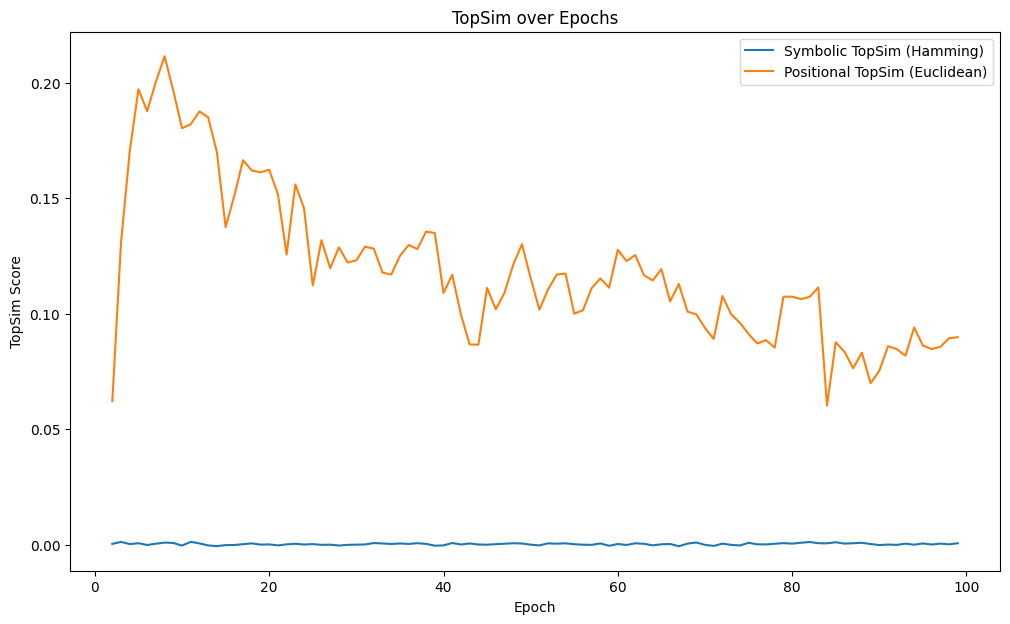

In [10]:
epochs = range(len(topsim_scores_over_epochs))

plt.figure(figsize=(12, 7))

plt.plot(epochs, topsim_scores_over_epochs, linestyle='-', label='Symbolic TopSim (Hamming)')
plt.plot(epochs, pos_topsim_scores_over_epochs, linestyle='-', label='Positional TopSim (Euclidean)')

plt.title('TopSim over Epochs')
plt.xlabel('Epoch')
plt.ylabel('TopSim Score')
plt.legend()

plt.show()

../logs/interactions/2025-06-16/gamesize10_human_gs_seed42/interactions/validation/epoch_40/interaction_gpu0
../logs/interactions/2025-06-16/gamesize10_human_gs_seed123/interactions/validation/epoch_47/interaction_gpu0
../logs/interactions/2025-06-16/gamesize10_human_gs_seed2025/interactions/validation/epoch_47/interaction_gpu0


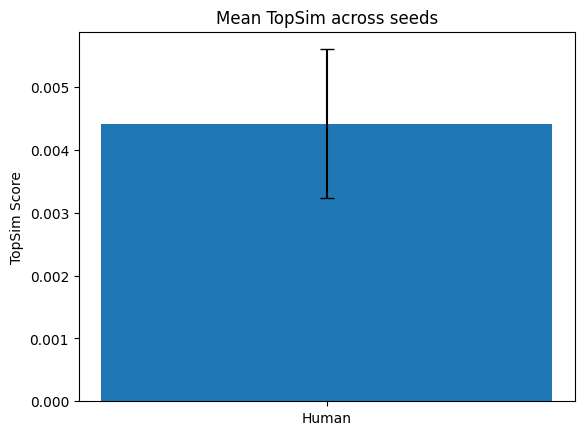

In [ ]:
import editdistance
logs_root = "../logs/interactions/2025-06-16"
seed_folders = [
    "gamesize10_bee_gs_seed42",
    "gamesize10_bee_gs_seed123",
    "gamesize10_bee_gs_seed2025",
]

scores = []
for seed in seed_folders:
    logs = load_latest_interaction(
        logs_root=logs_root,
        seed_folder=seed,
        split="validation",
        prefix="interaction_gpu0"
    )

    messages = logs.message.argmax(dim=-1).cpu().tolist()

    nest = np.stack(logs.aux_input["nest_pos"])
    food = np.stack(logs.aux_input["food_pos"])
    delta = food - nest
    dist = np.linalg.norm(delta, axis=1)
    theta = np.arctan2(delta[:,1], delta[:,0])
    meanings = np.stack([dist, theta], axis=1)

    ts = TopographicSimilarity.compute_topsim(
        meanings=meanings,
        messages=messages,
        meaning_distance_fn="euclidean",
        message_distance_fn=lambda x, y: editdistance.eval(x, y) / ((len(x) + len(y)) / 2)
    )
    scores.append(ts)

mean_score = np.mean(scores)
std_score  = np.std(scores)

fig, ax = plt.subplots()
ax.bar(['Human'], [mean_score], yerr=[std_score], capsize=5)
ax.set_ylabel('TopSim Score')
ax.set_title('Mean TopSim across seeds')
plt.show()

In [ ]:
import numpy as np
import editdistance
from scipy.optimize import linear_sum_assignment
from collections import Counter, defaultdict

def compute_cbm(messages, dist_bins, dir_bins, n_dist_bins, n_dir_bins):
    C = n_dist_bins + n_dir_bins
    Q = defaultdict(int)
    for i, msg in enumerate(messages):
        # map dir concepts to IDs n_dist_bins…n_dist_bins+n_dir_bins-1
        concepts = [ dist_bins[i], n_dist_bins + dir_bins[i] ]
        for w in msg:
            for v in concepts:
                Q[(w,v)] += 1

    W = max(w for msg in messages for w in msg) + 1
    mat = np.zeros((W, C), int)
    for (w,v), cnt in Q.items():
        mat[w,v] = cnt

    row, col = linear_sum_assignment(-mat)
    match_mass = mat[row, col].sum()
    norm = sum(max(len(msg), 2) for msg in messages)
    return match_mass / norm

dx = food[:,0] - nest[:,0]
dy = food[:,1] - nest[:,1]
distances = np.hypot(dx, dy)  
dirs = ["N","NE","E","SE","S","SW","W","NW"]
angles = (np.degrees(np.arctan2(dy, dx)) % 360)
dir_bins = np.array([
    int((angle + 22.5)//45) % 8
    for angle in angles
])
n_dist_bins = 1
quantiles = np.linspace(0, 1, n_dist_bins+1)
edges = np.quantile(distances, quantiles)
dist_bins = np.digitize(distances, edges[1:-1])

cbm = compute_cbm(
    messages=human_messages,
    dist_bins=dist_bins,
    dir_bins=dir_bins,
    n_dist_bins = n_dist_bins,
    n_dir_bins  = 8
)
print(f"Concept‐Best‐Matching score = {cbm:.4f}")


Concept‐Best‐Matching score = 0.2701
